In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import shutil

In [24]:
training_folder_name = 'C:/Users/admin/Desktop/Final Project/train' #foldername should be train
validation_folder_name = 'C:/Users/admin/Desktop/Final Project/val'
# All images are 128x128 pixels
img_size = (128, 128)

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

['Compost', 'Landfill', 'Recycle']


In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.10.2+cpu


In [38]:
from PIL import Image

# function to resize image
def resize_image(src_image, size=(224, 224), bg_color="white"): 
    from PIL import Image, ImageOps, ImageFile
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

In [39]:
def load_dataset(data_path):

    # Load all the images
    transformation = transforms.Compose([
        # Randomly augment the image data
            # Random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
   
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader

In [40]:
final_train_folder = 'C:/Users/admin/Desktop/Final Project/train'
# final_train_folder = 'C:/Users/admin/Desktop/Final Project/final_train'
train_loader, test_loader = load_dataset(final_train_folder)
batch_size = train_loader.batch_size
print("Data loaders ready to read", final_train_folder)

Data loaders ready to read C:/Users/admin/Desktop/Final Project/train


In [41]:
size = (128,128)
# Create the output folder if it doesn't already exist
if not os.path.exists(final_train_folder):
    os.makedirs(final_train_folder)

# Loop through each subfolder in the input folder
print('Transforming images...')
# print(os.walk(train_folder))
for root, folders, files in os.walk(train_folder):
    # print(root)
    for folder in folders:
        print('processing folder ' + folder)
        # Create a matching subfolder in the output dir
        saveFolder = os.path.join(final_train_folder,folder)
        if not os.path.exists(saveFolder):
            os.makedirs(saveFolder)
        # Loop through the files in the subfolder
        file_names = os.listdir(os.path.join(root,folder))
        for file_name in file_names:
            # Open the file
            file_path = os.path.join(root,folder, file_name)
            # print("reading " + file_path)
            image = Image.open(file_path)
            # Create a resized version and save it
            resized_image = resize_image(image, size)
            saveAs = os.path.join(saveFolder, file_name)
            # print("writing " + saveAs)
            resized_image.save(saveAs)

print('Done.')

Transforming images...
processing folder Compost


processing folder Landfill
processing folder Recycle
Done.


In [42]:
class Net(nn.Module):
    
    
    # Defining the Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # In the init function, we define each layer we will use in our model
        
        # Our images are RGB, so we have input channels = 3. 
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # This means that our feature tensors are now 32 x 32, and we've generated 24 of them
        
        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        
        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))  
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return torch.log_softmax(x, dim=1)
    
    def get_summary(self):
        print(self.summary())
    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

print(model)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=24576, out_features=3, bias=True)
)


In [43]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [44]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [45]:
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 128, 128]             336
         MaxPool2d-2           [-1, 12, 64, 64]               0
            Conv2d-3           [-1, 24, 64, 64]           2,616
         MaxPool2d-4           [-1, 24, 32, 32]               0
         Dropout2d-5           [-1, 24, 32, 32]               0
            Linear-6                    [-1, 3]          73,731
Total params: 76,683
Trainable params: 76,683
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 3.00
Params size (MB): 0.29
Estimated Total Size (MB): 3.48
----------------------------------------------------------------


In [47]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 100
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1


	Training batch 1 Loss: 1.031379
	Training batch 2 Loss: 1.046224
	Training batch 3 Loss: 1.058652
	Training batch 4 Loss: 1.028192
	Training batch 5 Loss: 1.058104
Training set: Average loss: 1.044510
Validation set: Average loss: 1.034444, Accuracy: 39/97 (40%)

Epoch: 2
	Training batch 1 Loss: 1.022713
	Training batch 2 Loss: 1.042925
	Training batch 3 Loss: 1.057468
	Training batch 4 Loss: 1.023323
	Training batch 5 Loss: 1.057121
Training set: Average loss: 1.040710
Validation set: Average loss: 1.030940, Accuracy: 39/97 (40%)

Epoch: 3
	Training batch 1 Loss: 1.017656
	Training batch 2 Loss: 1.040577
	Training batch 3 Loss: 1.056848
	Training batch 4 Loss: 1.019237
	Training batch 5 Loss: 1.056735
Training set: Average loss: 1.038211
Validation set: Average loss: 1.028092, Accuracy: 39/97 (40%)

Epoch: 4
	Training batch 1 Loss: 1.014114
	Training batch 2 Loss: 1.039053
	Training batch 3 Loss: 1.056770
	Training batch 4 Loss: 1.016015
	Training batch 5 Loss: 1.056827
Training set:

In [26]:
torch.save(model, 'weights.pth')

In [6]:
model = torch.load('C:/Users/admin/Desktop/GitHub/PyTorch/weights.pth')

In [7]:
model.eval()

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=24576, out_features=3, bias=True)
)

In [10]:
from PIL import Image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add a batch dimension
    return image

In [22]:
# image_path = 'C:/Users/admin/Desktop/Final Project/val/Recycle/00000006.jpg'
# image_path = 'C:/Users/admin/Desktop/GitHub/PyTorch/banana.jpg'
image_path = "C:/Users/admin/Desktop/Final Project/val/Recycle/metal14.jpg"
size = (128,128)
image = Image.open(image_path)
input_image = resize_image(image, size)
# resized_image.save('C:/Users/admin/Desktop/GitHub/PyTorch/banana.jpg')
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
input_image = transform(input_image)
input_image = input_image.unsqueeze(0)
# Step 4: Perform Inference
with torch.no_grad():
    output = model(input_image)
    print(output[0])
# Convert the output to probabilities using softmax
probabilities = torch.nn.functional.softmax(output[0], dim=0)
predicted_class = torch.argmax(probabilities).item()
print(predicted_class)

tensor([-0.5663, -3.3360, -0.9243])
0


In [29]:
# Defining Labels and Predictions
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model(data).data.numpy().argmax(1):
        predictions.append(prediction) 

Getting predictions from test set...


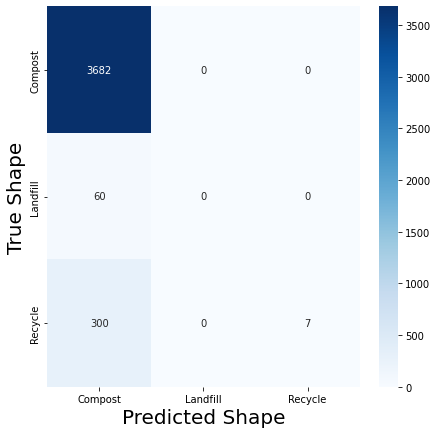

In [30]:
# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()